# Gini index

In [4]:
import numpy as np
import pandas as pd

In [5]:
def gini(labels):
    '''
    Input
        labels: a list like object with binary values
    return 
        the gini score
    '''
    count = np.bincount(labels)
    total = count.sum()
    zeros = count[0]
    ones = count[1]
    
    return 2 * (zeros/total) * (ones / total)

def weighted_gini(left_y, right_y):
    '''
    Calculate the expected gini score for two sets
    '''
    D_left = len(left_y)
    D_right = len(right_y)
    D = D_left + D_right
    
    return D_left/D * gini(left_y) + D_right/D * gini(right_y)

In [6]:
# load dataset
purchases = pd.read_csv('data/purchases_w9.csv')

# Don't include customer id or purchase
X = purchases.iloc[:, 1:-1]

# Target is purchase status (last column)
y = purchases.iloc[:, -1]

gini_values = []

for col in X.columns:
    
    left_y = y[X[col] == 1]
    right_y = y[X[col] == 0]
    
    gini_split = weighted_gini(left_y, right_y)
    
    print(f'{col} gini = {gini_split:.2f}')
    
    gini_values.append(gini_split)

best_idx = np.argmin(gini_values)

print(f'Optimal feature: {X.columns[best_idx]} with gini {gini_values[best_idx]:.2f}')

Education_High school gini = 0.36
Education_University gini = 0.36
Income_High gini = 0.39
Income_Low gini = 0.48
Income_Medium gini = 0.36
Marital Status_Married gini = 0.47
Marital Status_Single gini = 0.47
Age_21 gini = 0.48
Age_22 gini = 0.48
Age_25 gini = 0.48
Age_27 gini = 0.47
Age_32 gini = 0.48
Optimal feature: Income_Medium with gini 0.36


***

# Decision Tree with sklearn

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
default = pd.read_csv('data/default_w9.csv')
default.head()

default student      balance       income
0        0      No   729.526495  44361.62507
1        0     Yes   817.180407  12106.13470
2        0      No  1073.549164  31767.13895
3        0      No   529.250605  35704.49394
4        0      No   785.655883  38463.49588

In [9]:
default = pd.get_dummies(default)
default.head()

default      balance       income  student_No  student_Yes
0        0   729.526495  44361.62507           1            0
1        0   817.180407  12106.13470           0            1
2        0  1073.549164  31767.13895           1            0
3        0   529.250605  35704.49394           1            0
4        0   785.655883  38463.49588           1            0

In [10]:
X = default.iloc[:, 1:]
y = default['default']

print('The total number of default is {}.'.format(np.sum(y == 1)))
print('The total number of non-default is {}.'.format(np.sum(y == 0)))

The total number of default is 333.
The total number of non-default is 9667.


In [11]:
feature_names = X.columns
feature_names

Index(['balance', 'income', 'student_No', 'student_Yes'], dtype='object')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0, 
                                                    train_size=0.4)
print('train size:', len(y_train))
print('test size:', len(y_test))

train size: 4000
test size: 6000


In [13]:
default_clf = DecisionTreeClassifier(max_depth = 2, class_weight = 'balanced')
default_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2)

In [14]:
print(f'Proportion of defaults in test set: {sum(y_test)/len(y_test):.4f}')

Proportion of defaults in test set: 0.0378


In [15]:
y_pred = default_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4708 1065]
 [  20  207]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      5773
           1       0.16      0.91      0.28       227

    accuracy                           0.82      6000
   macro avg       0.58      0.86      0.59      6000
weighted avg       0.96      0.82      0.87      6000



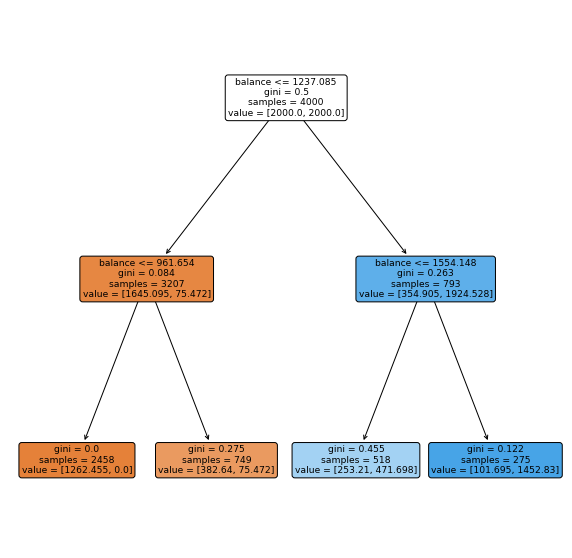

In [16]:
plt.figure(figsize=(10,10))

tree.plot_tree(default_clf, 
               rounded=True, 
               filled=True, 
               feature_names=feature_names)
plt.show()

In [17]:
# WARNING: The hyperparameter selection should NOT be done on test data.
#          Here we are just evaluating the final performance with different values max_depth and report the results.
max_d = 300
# Grid search for max_depth
acc = np.zeros(max_d)

for d in range(1,max_d+1,1):
    t_ = DecisionTreeClassifier(max_depth = d, class_weight = 'balanced')
    t_.fit(X_train, y_train)
    acc[d-1] = t_.score(X_test,y_test)

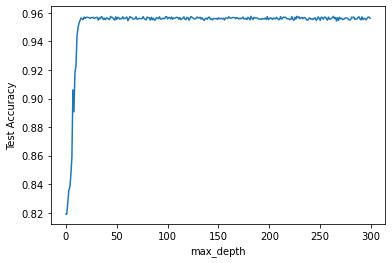

In [18]:
plt.figure()
plt.plot(acc)
plt.xlabel('max_depth')
plt.ylabel('Test Accuracy')
plt.show()

***

# Bootstrap and Bagging

In [19]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import mode

In [20]:
def bagged_trees(X_train, y_train, X_test, y_test, sample_size=None, n_trees=5, display=True):

    if sample_size == None:
        sample_size = X_train.shape[0]

    tree_preds = np.zeros((X_test.shape[0], n_trees))

    for i in range(n_trees):
        
        # randomly select samples from the training set with replacement
        rows = np.random.choice(X_train.shape[0], sample_size, replace=True)
        x_train_tree = X_train.iloc[rows, :]
        y_train_tree = y_train.iloc[rows]

        # use sklearn default settings (which gives us a large tree!)
        clf = DecisionTreeClassifier()
        clf.fit(x_train_tree, y_train_tree)

        # evaluate current tree on test set and store the prediction
        tree_preds[:, i] = clf.predict(X_test)

    # take the mode of predictions from the trees (along the columns)
    final_pred, _ = mode(tree_preds, axis=1)
    final_pred = final_pred.squeeze()

    # save the classification report into a dict
    cr = classification_report(y_test, final_pred, output_dict = 1)

    if display:
        print(confusion_matrix(y_test, final_pred))
        print(classification_report(y_test, final_pred))
    
    return final_pred, cr

## - Parameter: Bootstrap Sample Size

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# # import defined bagged_trees from model.py module (the previous cell)
# from model import bagged_trees

In [23]:
# load dataset
data = pd.read_csv('data/cancer_dataset_w9.csv')
X = data.iloc[:, :-1]
y = data['benign']

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [24]:
# Proportion of dataset size ([0.1 0.325 0.55 0.775 1])
ratios = np.linspace(0.1, 1, num=5, endpoint=True)

# Number of repetitons and number of ratio to test
repeats = 30

# create a placeholder for all results
all_results = np.zeros((len(ratios),repeats))

In [25]:
for idx_ratio in range(len(ratios)):
    r = ratios[idx_ratio]

    # Convert proportion to sample size
    N = int(r * X_train.shape[0])

    for idx_rep in range(repeats):
        # Build the model
        _pred, _acc = bagged_trees(X_train, y_train, X_test, y_test, sample_size=N, display=0)
        
        # Record the accuracy
        all_results[idx_ratio, idx_rep] = _acc.get('accuracy')

In [26]:
mean_accuracy = np.mean(all_results, axis=1)
std_accuracy = np.std(all_results, axis=1) # standard deviation used for plotting

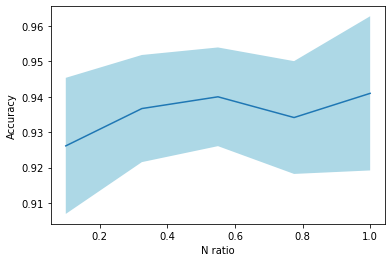

In [27]:
plt.figure()
plt.plot(ratios, mean_accuracy)
plt.fill_between(ratios, mean_accuracy + std_accuracy, mean_accuracy - std_accuracy, facecolor='lightblue')
plt.xlabel('N ratio')
plt.ylabel('Accuracy')
plt.show()

## - Parameter: Ensemble Size

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [31]:
# load dataset
data = pd.read_csv('data/cancer_dataset_w9.csv')
X = data.iloc[:, :-1]
y = data['benign']

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [32]:
# Number of times to repeat the experiment
repeats = 30

# Range of trees to check
n_trees = np.arange(1, 11, 1)

In [33]:
all_results = np.zeros((len(n_trees),repeats))
for idx_trees in range(len(n_trees)):
    # YOUR CODE HERE
    n = n_trees[idx_trees]
    for idx_rep in range(repeats):
        _pred, _acc = bagged_trees(X_train, y_train, X_test, y_test, n_trees=n, display=False)

        all_results[idx_trees, idx_rep] = _acc.get('accuracy')

In [34]:
mean_accuracy = np.mean(all_results, axis=1)
std_accuracy = np.std(all_results, axis=1) # standard deviation used for plotting

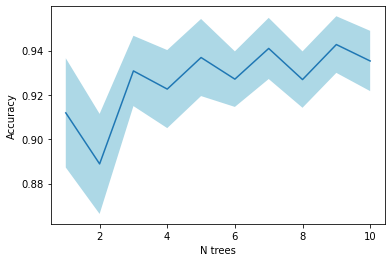

In [35]:
plt.figure()
plt.plot(n_trees, mean_accuracy)
plt.fill_between(n_trees, mean_accuracy + std_accuracy, mean_accuracy - std_accuracy, facecolor='lightblue')
plt.xlabel('N trees')
plt.ylabel('Accuracy')
plt.savefig('plot.png')
plt.show()

## Bagging Tree Size
A bagged ensemble has a lower variance, in terms of bias-variance tradeoff, than a single decision tree. However the bias remains the same!

Since there is no reduction in bias you need to use relatively complex trees. Typically bagging doesn't work well with decision stumps.

***

# Random Forests

In [36]:
import numpy as np
from scipy.stats import mode
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
def random_forest(X_train, y_train, X_test, y_test, 
                  sample_size=None, 
                  n_trees=5, 
                  p=None, 
                  display=True):

    if sample_size == None:
        sample_size = X_train.shape[0]

    if p == None:
        p = int(np.sqrt(X_train.shape[1]))

    tree_preds = np.zeros((X_test.shape[0], n_trees))

    for i in range(n_trees):

        # randomly select samples from the training set
        rows = np.random.choice(X_train.shape[0], sample_size)
        x_train_tree = X_train.iloc[rows, :]
        y_train_tree = y_train.iloc[rows]

        # use p randomly selected features at each split
        clf = DecisionTreeClassifier(max_features=p)
        clf.fit(x_train_tree, y_train_tree)

        # evaluate current tree on test set
        tree_preds[:, i] = clf.predict(X_test)

    # take the mode of predictions from the trees
    final_pred, _ = mode(tree_preds, axis=1)
    final_pred = final_pred.squeeze()

    # save the classification report into a dict
    cr = classification_report(y_test, final_pred, output_dict=1)

    if display:
        print(confusion_matrix(y_test, final_pred))
        print(classification_report(y_test, final_pred))

    return final_pred, cr

## - Parameter: Number of Features

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [40]:
# load dataset
data = pd.read_csv('data/cancer_dataset_w9.csv')
X = data.iloc[:, :-1]
y = data['benign']

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [41]:
# Number of times to repeat the experiment
repeats = 100

# Range of p to check
p_vals = np.arange(1, X_train.shape[1] + 1, 1)

all_results = np.zeros((len(p_vals),repeats))
for idx_p in range(len(p_vals)):
    p = p_vals[idx_p]
    for idx_rep in range(repeats):
        _pred, _acc = random_forest(X_train, y_train, X_test, y_test, n_trees=10, p=p, display=0)
        all_results[idx_p, idx_rep] = _acc.get('accuracy')

In [42]:
mean_accuracy = np.mean(all_results, axis=1)
std_accuracy = np.std(all_results, axis=1) # standard deviation used for plotting

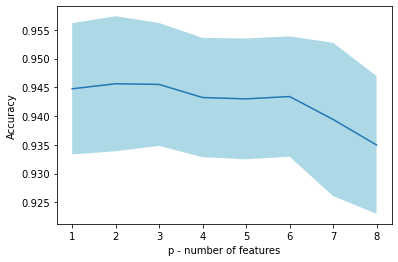

In [43]:
plt.figure()
plt.plot(p_vals, mean_accuracy)
plt.fill_between(p_vals, mean_accuracy + std_accuracy, mean_accuracy - std_accuracy, facecolor='lightblue')
plt.xlabel('p - number of features')
plt.ylabel('Accuracy')
plt.show()

***

# Random forest with sklearn

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(0)

In [51]:
data = pd.read_csv('data/cancer_dataset_w9.csv')
X = data.iloc[:, :-1]
y = data['benign']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [52]:
# Specify the parameter combinations to check
param_grid = {
    'n_estimators': np.arange(1, 11, 1),
    'max_features': np.arange(1, X_train.shape[1]+1, 1)
}

# We will use repeated k-fold cross validation
folds = RepeatedKFold(random_state=0)

# Create the grid search object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=folds, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [53]:
best_rf = grid_search.best_estimator_

In [54]:
y_pred = best_rf.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[62  1]
 [10 98]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        63
           1       0.99      0.91      0.95       108

    accuracy                           0.94       171
   macro avg       0.93      0.95      0.93       171
weighted avg       0.94      0.94      0.94       171



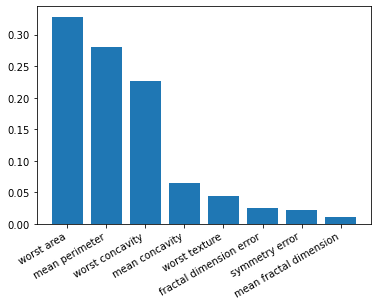

In [55]:
f_importance = pd.Series(best_rf.feature_importances_, index = X.columns).sort_values(ascending = False)

plt.figure()
plt.bar(f_importance.index,f_importance)
plt.xticks(rotation = 30, ha='right')
plt.show()